# ADS 509 Assignment 5.1: Topic Modeling
## Ghassan Seba

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [1]:
# !pip install pyLDAvis==3.4.1 --user 
# !pip install spacy
# !pip install numpy==1.23.5
# !python -m spacy download en_core_web_sm

In [2]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
import nltk
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [3]:
# # Check Python version => 3.9.0
# !python --version

In [4]:
# add any additional libaries you need here
nltk.download('brown', quiet=True)


True

In [5]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [8]:
# # Understand contents of df
# df.head(50)

In [9]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<Axes: xlabel='category'>

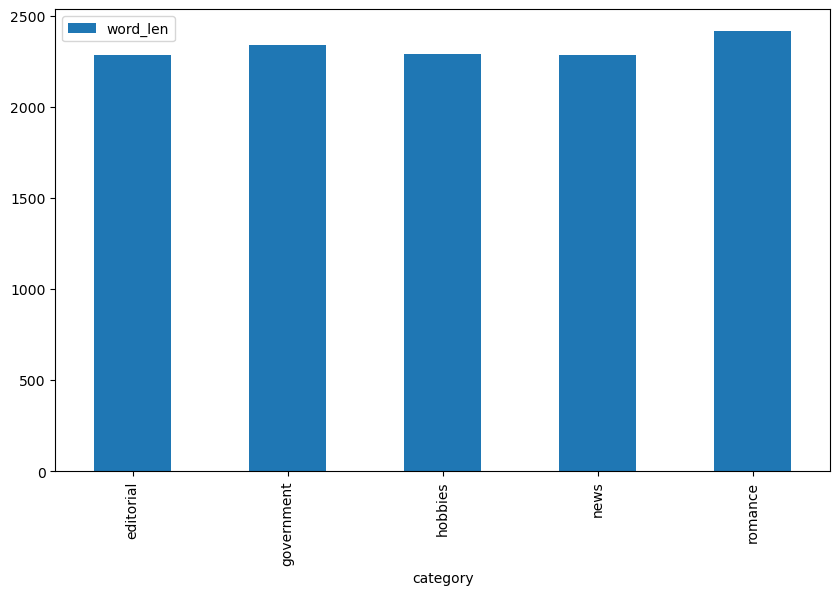

In [10]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [11]:
# Process stop words to match text splitting due to warning
processed_stopwords_CV = list(CountVectorizer().build_tokenizer()(" ".join(stopwords)))

# Create the CountVectorizer with consistent stop words
count_text_vectorizer = CountVectorizer(stop_words=processed_stopwords_CV, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4939)

In [12]:
# Convert to dense matrix
dense_matrix_CV = count_text_vectors.toarray()

# Get feature names from vectorizer
feature_names_CV = count_text_vectorizer.get_feature_names_out()

# Convert to DataFrame with feature names as columns and document IDs as index
df_vectors_CV = pd.DataFrame(dense_matrix_CV, columns=feature_names_CV, index=df['id'])

# Display the DataFrame
df_vectors_CV.head()  

,00,000,10,100,11,12,120,13,14,15,...,yes,yesterday,yield,york,young,younger,youngsters,youth,zone,zoning
id,,,,,,,,,,,,,,,,,,,,,
cb01,0,3,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
cb02,0,3,0,0,0,1,0,1,0,0,...,0,0,0,3,0,0,0,0,2,0
cb03,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
cb04,0,1,0,0,0,2,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
cb05,0,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Process stop words to match text splitting due to warning
processed_stopwords_TV = list(TfidfVectorizer().build_tokenizer()(" ".join(stopwords)))

# Create the CountVectorizer with consistent stop words
tfidf_text_vectorizer = TfidfVectorizer(stop_words=processed_stopwords_TV, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4939)

In [14]:
# Convert to Dense matrix of TF-IDF vectors
dense_matrix_TV = tfidf_text_vectors.toarray()

# Get Feature names from TfidfVectorizer
feature_names_TV = tfidf_text_vectorizer.get_feature_names_out()

# DataFrame with feature names as columns and document IDs as index
df_vectors_TV = pd.DataFrame(dense_matrix_TV, columns=feature_names_TV, index=df['id'])

# First 5 rows of the DataFrame
df_vectors_TV.head()


,00,000,10,100,11,12,120,13,14,15,...,yes,yesterday,yield,york,young,younger,youngsters,youth,zone,zoning
id,,,,,,,,,,,,,,,,,,,,,
cb01,0.0,0.046852,0.0,0.000000,0.000000,0.000000,0.0,0.023450,0.0,0.019456,...,0.0,0.0,0.000000,0.016895,0.000000,0.0,0.0,0.0,0.000000,0.0
cb02,0.0,0.040107,0.0,0.000000,0.000000,0.015896,0.0,0.020074,0.0,0.000000,...,0.0,0.0,0.000000,0.043389,0.000000,0.0,0.0,0.0,0.062348,0.0
cb03,0.0,0.000000,0.0,0.041794,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.034956,0.0,0.0,0.0,0.000000,0.0
cb04,0.0,0.016735,0.0,0.000000,0.000000,0.039797,0.0,0.000000,0.0,0.020849,...,0.0,0.0,0.036429,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
cb05,0.0,0.014687,0.0,0.018843,0.019635,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

***A: The two DataFrames, `count_text_vector` and `tfidf_text_vectors,` both hold tokenized word data for the articles but in different forms. `count_text_vectors` contains the `raw word counts,` showing how many times each word appears in each article in `"The Brown Corpus."` The `tfidf_text_vectors` hold the `TF-IDF scores,` which adjust these counts based on how `important a word is` relative to the entire dataset, giving more weight to unique words and less to common ones. Both DataFrames provide information on the words in each article but with different focuses: one on frequency and the other on significance. This is evident when the dataframes are displayed as the `count_text_vector` shows discrete counts as values and the `tfidf_text_vectors` show continuous values that represent calculated scores.***

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [15]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [16]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.89)
  didn (0.46)
  thought (0.42)
  man (0.38)
  don (0.35)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.63)
  mr (0.79)
  said (0.63)
  miss (0.53)
  car (0.51)

Topic 04
  game (1.02)
  league (0.75)
  ball (0.73)
  baseball (0.71)
  team (0.67)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [17]:
# Assign each document to the most relevant NMF topic
df['nmf_topic'] = np.argmax(W_text_matrix, axis=1)

# Tally Brown categories for each NMF topic
nmf_category_tally = pd.crosstab(df['nmf_topic'], df['category'])

# Display the results
for topic in range(5):
    print(f"\nTopic {topic}:")
    print(nmf_category_tally.loc[topic])


Topic 0:
category
editorial     20
government     4
hobbies        0
news           8
romance        0
Name: 0, dtype: int64

Topic 1:
category
editorial      4
government     0
hobbies        8
news           0
romance       29
Name: 1, dtype: int64

Topic 2:
category
editorial      2
government    26
hobbies       26
news          11
romance        0
Name: 2, dtype: int64

Topic 3:
category
editorial      0
government     0
hobbies        1
news          17
romance        0
Name: 3, dtype: int64

Topic 4:
category
editorial     1
government    0
hobbies       1
news          8
romance       0
Name: 4, dtype: int64


Q: How does your five-topic NMF model compare to the original Brown categories? 

***A: The NMF model groups articles based on common themes very effectively. However, it also identifies some overlap between categories. This overlap is interesting as it may indicate potential relationships between the topics. For example, editorial and news articles, as well as hobbies and government articles, appear to share similarities. While the boundaries between some of the categories may be fuzzy, I can see how valuable the insights could be with further analysis.***

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [18]:
# Fit the LSA model with 5 topics
svd_para_model = TruncatedSVD(n_components=5, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_svd_para_matrix = svd_para_model.components_

# Assign each document to the most relevant LSA topic
df['lsa_topic'] = np.argmax(W_svd_para_matrix, axis=1)

# Tally Brown categories for each LSA topic
lsa_category_tally = pd.crosstab(df['lsa_topic'], df['category'])

In [19]:
# Display the tally
lsa_category_tally

category,editorial,government,hobbies,news,romance
lsa_topic,,,,,
0,27,30,36,34,21
1,0,0,0,0,8
3,0,0,0,3,0
4,0,0,0,7,0


In [20]:
# View singular values
svd_para_model.singular_values_

array([3.69734343, 2.24163352, 1.69712548, 1.66355215, 1.56267787])

Q: How does your five-topic LSA model compare to the original Brown categories? 

***A: It appears that topic 0 shows considerable overlap across several Brown categories, pulling in documents from editorial, government, hobbies, news, and romance, indicating that it captures a broad, shared theme. In contrast, the rest of the topics (1, 3, and 4) are much more focused, with little overlap, as they mainly contain documents from specific categories like romance or news.*** 

In [21]:
# Display the top words for each topic
display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (4.32)
  didn (2.89)
  thought (2.43)
  mrs (2.18)
  got (2.16)

Topic 02
  mrs (3.11)
  mr (1.72)
  said (1.02)
  kennedy (0.80)
  president (0.77)

Topic 03
  mrs (27.75)
  club (6.23)
  game (6.17)
  jr (5.32)
  dallas (5.10)

Topic 04
  game (4.45)
  league (3.16)
  baseball (3.13)
  ball (3.03)
  team (2.88)


Q: What is your interpretation of the display topics output? 

***A: The display topics output shows that Topic 00 has very generic terms like "said" and "mr," which may explain why it overlaps with so many categories. The remaining topics, while still somewhat generic, show more context. For example, Topic 04 is clearly about sports (news) with terms like "baseball" and "team." These more specific words in the other topics help limit them to fewer categories.***

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [22]:
# Fit LDA model with 5 topics
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [23]:
# Display top words for each topic
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  house (0.69)
  clay (0.60)
  shelter (0.47)
  inch (0.46)
  cut (0.45)

Topic 01
  said (1.24)
  man (0.58)
  old (0.55)
  little (0.54)
  good (0.49)

Topic 02
  feed (1.07)
  af (0.74)
  pool (0.55)
  head (0.45)
  high (0.43)

Topic 03
  state (0.83)
  states (0.59)
  united (0.53)
  government (0.49)
  000 (0.41)

Topic 04
  mrs (1.51)
  said (1.06)
  mr (0.84)
  home (0.67)
  week (0.51)


Q: What inference do you draw from the displayed topics for your LDA model? 

***A: The displayed topics show that the LDA model identifies clear and distinct themes. For example, Topic 00 relates to construction with words like "house" and "cut," while Topic 03 focuses on government with terms like "state" and "government." Topic 01 captures dialogue or personal narratives, and Topic 04 centers on domestic life with words like "mrs" and "home." Overall, this model does a much better job of effectively grouping topics into their respective themes.***

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

***A: The five-topic LDA model shows that Topic 3 combines documents from editorial, government, and news, suggesting it covers a broad theme across these categories. Topic 1 is mainly focused on romance and hobbies, while Topics 0 and 2 primarily include hobbies with a few documents from government and news. Topic 4 is mostly made up of news documents, making it more specific. The LDA model captures some clear themes but still shows an overlap between categories like editorial, government, and news.***

In [24]:
# Assign each document to the most relevant LDA topic
df['lda_topic'] = np.argmax(W_lda_text_matrix, axis=1)

# Tally Brown categories for each LDA topic
lda_category_tally = pd.crosstab(df['lda_topic'], df['category'])

# Display the tally
lda_category_tally

category,editorial,government,hobbies,news,romance
lda_topic,,,,,
0,0,1,11,1,0
1,6,0,9,1,29
2,0,1,8,0,0
3,21,28,8,24,0
4,0,0,0,18,0


In [25]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [26]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

***A: The scatterplot shows that Topic 4 is the largest and most dominant, while Topic 3 is smaller and more distinct from other topics, indicating a focused theme. Topics 1, 2, and 5 are closer together, suggesting they share more similarities. The salient terms graph highlights keywords associated with the specific topic selected in the principal component scatterplot and shows which terms are most relevant to the chosen topic. It does this by showing the overall term frequency compared with the term frequency within the selected group.***


<center><b>References:</b></center>

- Albrecht, J., Ramachandran, S., & Winkler, C. (2020). *Blueprints for text analytics using Python.* O'Reilly.
- Pankaj. (2022, August 3). *Python string encode() decode().* DigitalOcean. https://www.digitalocean.com/community/tutorials/python-string-encode-decode
- Jain, Y. (2021, February 23). *How to convert a string to UTF-8 in Python?* Studytonight. https://www.studytonight.com/python-howtos/how-to-convert-a-string-to-utf8-in-python
- Singh, V. K., & Obi Tulton, A. (2022, November 30). *How to work with Unicode in Python.* DigitalOcean. https://www.digitalocean.com/community/tutorials/how-to-work-with-unicode-in-python
- Solomon, B. (2021, August 29). *demoji (Version 1.1.0)* [Python package]. PyPI. https://pypi.org/project/demoji/
- pythontutorial.net. (2023). *Python regex sub().* https://www.pythontutorial.net/python-regex/python-regex-sub/
- Unicode Table. (n.d.). *UTF-8 encoding table and Unicode characters: Code points U+2000 to U+207F.* Retrieved from https://www.utf8-chartable.de/unicode-utf8-table.pl?start=8192&number=128&utf8=string-literal
- OpenAI. (2023). ChatGPT (October 5 version) [Large language model]. https://chat.openai.com/
- scikit-learn developers. (2024). *Feature extraction.* Scikit-learn. https://scikit-learn.org/stable/modules/feature_extraction.html
- Saket, S. (2020, January 12). *Count vectorizer vs TFIDF vectorizer | Natural language processing.* LinkedIn. https://www.linkedin.com/pulse/count-vectorizers-vs-tfidf-natural-language-processing-sheel-saket/
- Jablonski, J. (2023, October 18). *Python's F-String: An improved string interpolation and formatting tool.* Real Python. https://realpython.com/python-f-strings/
- Shah, F. P., & Patel, V. (2016). *A review on feature selection and feature extraction for text classification.* 2016 International Conference on Wireless Communications, Signal Processing and Networking (WiSPNET), 2264–2268. https://doi.org/10.1109/WiSPNET.2016.
- Bird, S., Klein, E., & Loper, E. (2019). *Accessing text corpora and lexical resources.* Natural Language Toolkit. http://www.nltk.org/book/ch02.html
- DataCamp. (2024, January 31). *A beginner's guide to Python for loops: Mastering for i in range.* DataCamp. https://www.datacamp.com/tutorial/python-for-i-in-range
- NumPy Developers. (2024). *numpy.argmax.* NumPy. https://numpy.org/doc/2.0/reference/generated/numpy.argmax.html